In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
% matplotlib inline
from six.moves import cPickle
from sklearn.preprocessing import LabelEncoder
from six.moves import cPickle
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
import graphviz

In [2]:
cntt = cPickle.load(open('./Dump/cntt.pkl', 'rb'))
fpinfo = cPickle.load(open('./Dump/fpinfo.pkl', 'rb'))

In [3]:
target = fpinfo.columns
cntt_fpinfo = pd.merge(cntt, fpinfo, on='CLLT_FP_PRNO', how='inner')

In [4]:
features = cntt_fpinfo.columns
train = cntt_fpinfo.loc[cntt_fpinfo['DIVIDED_SET'] == 1, features]
test = cntt_fpinfo.loc[cntt_fpinfo['DIVIDED_SET'] == 2, features]
cPickle.dump(cntt_fpinfo, open('./Dump/cntt_fpinfo.pkl', 'wb'), -1)
cPickle.dump(train, open('./Dump/cntt_fpinfo_train.pkl', 'wb'), -1)
cPickle.dump(test, open('./Dump/cntt_fpinfo_test.pkl', 'wb'), -1)

In [5]:
y = train['SIU_CUST_YN'].values
skf = StratifiedKFold(y, n_folds=10)
train_idx, valid_idx = next(iter(skf))

In [6]:
cntt_fpinfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112928 entries, 0 to 112927
Data columns (total 35 columns):
POLY_NO           112928 non-null int64
CUST_ID           112928 non-null int64
CUST_ROLE         112928 non-null int64
IRKD_CODE_DTAL    112928 non-null int64
IRKD_CODE_ITEM    112928 non-null int64
GOOD_CLSF_CDNM    112928 non-null int64
CLLT_FP_PRNO      112928 non-null float64
REAL_PAYM_TERM    112928 non-null int64
SALE_CHNL_CODE    112928 non-null int64
CNTT_STAT_CODE    112928 non-null int64
PAYM_CYCL_CODE    112928 non-null float64
MAIN_INSR_AMT     112928 non-null float64
SUM_ORIG_PREM     112928 non-null float64
RECP_PUBL         112928 non-null float64
CNTT_RECP         112928 non-null float64
MNTH_INCM_AMT     112928 non-null float64
DISTANCE          112928 non-null float64
CNTT_YM_Y         112928 non-null int64
CNTT_YM_M         112928 non-null int64
EXPR_YM_Y         112928 non-null int64
EXPR_YM_M         112928 non-null int64
EXTN_YM_Y         112928 non-null

In [7]:
# 'POLY_NO' is useless feature
X_train = train.iloc[train_idx]
X_valid = train.iloc[valid_idx]
y_train = X_train['SIU_CUST_YN']
y_valid = X_valid['SIU_CUST_YN']
X_train.drop(['CUST_ID', 'SIU_CUST_YN', 'DIVIDED_SET'], axis=1, inplace=True)
X_valid.drop(['CUST_ID', 'SIU_CUST_YN', 'DIVIDED_SET'], axis=1, inplace=True)

/home/isystems/Dropbox/Unist_iSystem/[2016]2summer/Cowork/suhyun/suvenv/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/isystems/Dropbox/Unist_iSystem/[2016]2summer/Cowork/suhyun/suvenv/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

param = {}
# Model setting
param['objective'] = 'binary:logistic'
param['booster'] = 'gbtree'
param['eval_metric'] = 'auc'

# weight regularization
param['Eta'] = 0.3
param['Lambda'] = 10.0
param['alpha'] = 10.0

# partitioning regularization
param['Gamma'] = 1.0
param['Max_depth'] = 20
param['min_child_weight'] = 20

# sampling regularization
param['Subsample'] = 0.6
param['Colsample_bytree'] = 1.0

# iteration regularization
num_round = 200
early_stopping_rounds = 10

# To use early stopping, there should be stopping material which is validation set
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

bst = xgb.train(param, dtrain, num_round, evals=watchlist,
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=True)

[0]	train-auc:0.624912	eval-auc:0.565365
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.643941	eval-auc:0.635824
[2]	train-auc:0.654583	eval-auc:0.640913
[3]	train-auc:0.66932	eval-auc:0.646794
[4]	train-auc:0.680558	eval-auc:0.644378
[5]	train-auc:0.688778	eval-auc:0.64224
[6]	train-auc:0.698	eval-auc:0.641188
[7]	train-auc:0.713393	eval-auc:0.642219
[8]	train-auc:0.724039	eval-auc:0.635598
[9]	train-auc:0.72759	eval-auc:0.635725
[10]	train-auc:0.733092	eval-auc:0.647214
[11]	train-auc:0.736398	eval-auc:0.643612
[12]	train-auc:0.746603	eval-auc:0.647154
[13]	train-auc:0.75328	eval-auc:0.64212
[14]	train-auc:0.757369	eval-auc:0.639531
[15]	train-auc:0.761067	eval-auc:0.635787
[16]	train-auc:0.766503	eval-auc:0.618441
[17]	train-auc:0.770366	eval-auc:0.611311
[18]	train-auc:0.777313	eval-auc:0.621721
[19]	train-auc:0.780677	eval-auc:0.6227
[20]	train-auc:0.788388	eval-auc:0.6256

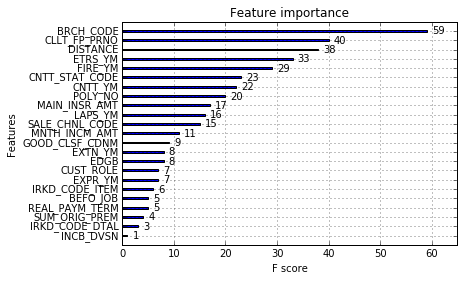

In [10]:
xgb.plot_importance(bst)
plt.show()